In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import warnings

import CM4Xutils
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xhistogram

import gsw, xwmt
import zarr

In [114]:
import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.rcParams.update({'font.size': 12})

In [124]:
xgcm.__version__, xwmt.__version__

('0.8.2.dev15+g7492277', '0.1.0')

### Load data and create metadata structures

Add layer interface (just because my `CM4Xutils`) utility function `ds_to_grid` needs it.

In [117]:
ds = xr.concat([
    xr.open_zarr("/work/hfd/ftp/CM4Xp25_historical_transient_tracers.zarr"),
    xr.open_zarr("/work/hfd/ftp/CM4Xp25_ssp585_transient_tracers.zarr/"),
], dim="year")
ds = add_estimated_layer_interfaces(ds)
grid = CM4Xutils.ds_to_grid(ds)

### Examples analysis and visualization of output on generalized vertical coordinate grid

In [131]:
kwargs = {"xh": -165, "year": 2000}
σ2 = ds['sigma2'].sel(method="nearest", **kwargs).compute()
z = ds.z.sel(method="nearest", **kwargs).compute() # broadcast vertical coordinate to two-dimensional mesh





In [ ]:
y

/vftmp/Henri.Drake/pid5324/ipykernel_4163/2049297357.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(y,z,σ2.transpose(), cmap=cmocean.cm.dense, vmin=35, vmax=37.5)


Text(0, 0.5, 'elevation [m]')

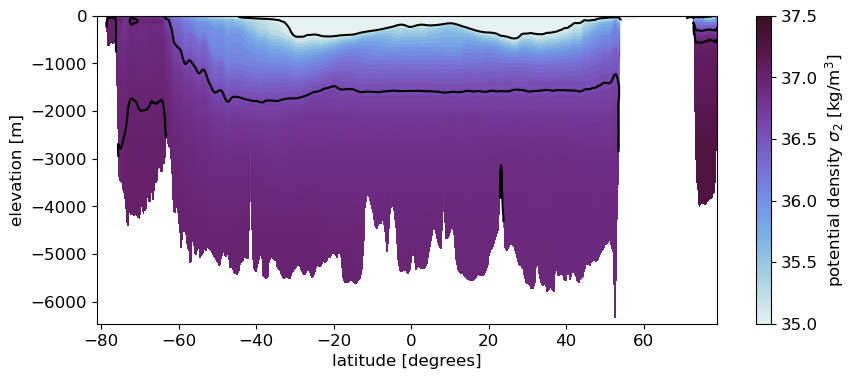

In [154]:
_, y = np.meshgrid(σ2.zl, σ2.geolat) # broadcast latitude

fig, ax = plt.subplots(1,1,figsize=(10, 4))
plt.pcolormesh(y,z,σ2.transpose(), cmap=cmocean.cm.dense, vmin=35, vmax=37.5)
plt.colorbar(label=r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
plt.contour(
    y,
    z,
    σ2.transpose(),
    levels=[35, 36.6, 37],
    colors="k"
);
plt.xlabel("latitude [degrees]")
plt.ylabel("elevation [m]")

### Horizontal section at specific depth

Note: `xh` and `yh` are just nominal grid coordinates! The actual coordinates are the curvilinear fields `geolon` and `geolat`!

In [137]:
σ2_slice = wm.grid.transform(
    ds['sigma2'],
    "Z",
    np.array([-4000]),
    target_data=ds['z'],
    method="linear"
)

/vftmp/Henri.Drake/pid5324/ipykernel_4163/164869229.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(
/vftmp/Henri.Drake/pid5324/ipykernel_4163/164869229.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


Text(0, 0.5, 'latitude')

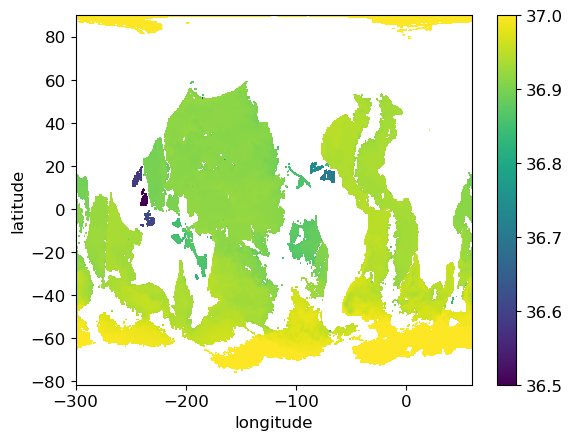

In [143]:
plt.pcolor(
    σ2_slice.geolon,
    σ2_slice.geolat,
    σ2_slice.isel(year=-1).squeeze(),
    vmin=36.5, vmax=37
)
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

In [145]:
zi = grid.interp(ds.z.sel(year=2023), "Z", boundary="extend").compute()
cfcthk = (ds.cfc11*ds.thkcello).sel(year=2023).compute()
cfc_mass_density = wm.grid.transform(
    cfcthk.fillna(0.),
    "Z",
    np.array([-8000, -4000]),
    target_data=zi,
    method="conservative"
).isel(z=0).compute()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


/vftmp/Henri.Drake/pid5324/ipykernel_4163/3726018251.py:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(


Text(0, 0.5, 'latitude')

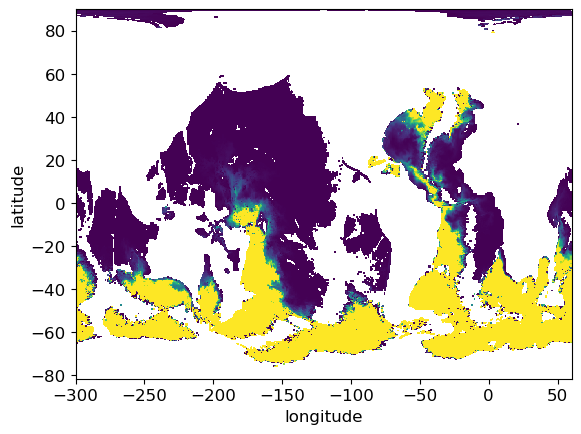

In [155]:
plt.pcolor(
    ds.geolon,
    ds.geolat,
    cfc_mass_density.where(cfc_mass_density!=0),
    vmax=1e-8
)
plt.xlabel("longitude")
plt.ylabel("latitude")

### Layer-wise inventory

In [119]:
sigma2_i = np.array([0, 36.7, 36.96, 50])
layer_labels = ["Upper layer", "Deep layer", "Bottom layer"]
layer_colors = ["goldenrod", "seagreen", "darkslateblue"]

years = [1960, 1980, 2000, 2020, 2050, 2099]

In [120]:
dV = ds.areacello*ds.thkcello
volume_binned = grid.transform(
    dV,
    "Z",
    sigma2_i,
    target_data=ds.sigma2,
    method="conservative"
).rename({"sigma2": "sigma2_l"})
layer_inventory = volume_binned.sum(["xh", "yh"]).compute()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [121]:
# NOTE: Annual mean outcrop area is not particularly meaningful because the densest
# isopycnals only outcrop in winter! We should use monthly means for this metric instead!

outcrop_area = xhistogram.xarray.histogram(
    ds.sigma2.isel(zl=0),
    bins=sigma2_i,
    dim=("xh", "yh",),
    weights=ds.areacello,
    bin_dim_suffix="_l",
).compute()

In [122]:
cfc11_content = (ds.cfc11.fillna(0.))*ds.areacello*ds.thkcello
cfc11_binned = grid.transform(
    cfc11_content,
    "Z",
    sigma2_i,
    target_data=ds.sigma2,
    method="conservative"
).rename({"sigma2": "sigma2_l"})
cfc11_layer_inventory = cfc11_binned.sum(["xh", "yh"]).compute()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


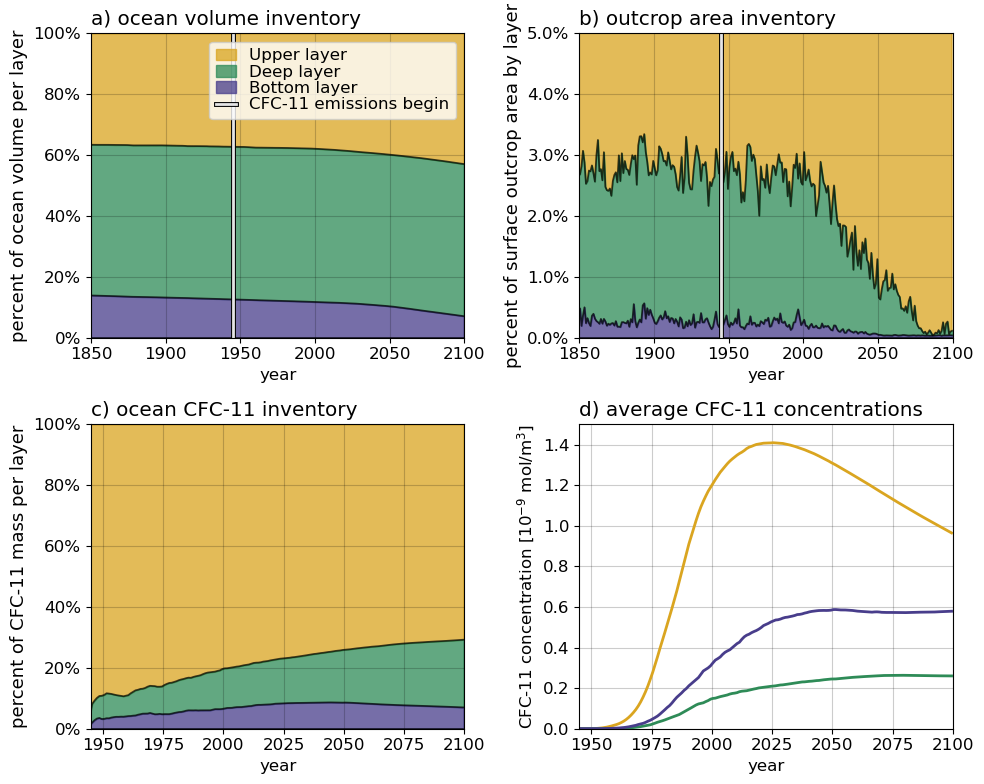

In [123]:
fig, axes = plt.subplots(2,2,figsize=(10,8))
for k, label, color in zip([0,1,2], layer_labels, layer_colors):
    
    ax = axes.flatten()[0]
    x = layer_inventory.year
    x = np.concatenate(([x[0] - 0.5], x+0.5, [x[-1] + 0.5]))
    y1 = 100 - layer_inventory.isel(sigma2_l=slice(0,k)).sum("sigma2_l") / layer_inventory.sum("sigma2_l")*100
    y1 = np.concatenate(([y1[0]], y1, [y1[-1]]))
    y2 = 100 - layer_inventory.isel(sigma2_l=slice(0,k+1)).sum("sigma2_l") / layer_inventory.sum("sigma2_l")*100
    y2 = np.concatenate(([y2[0]], y2, [y2[-1]]))
    
    ax.fill_between(x, y1, y2, label=label, color=color, alpha=0.75)
    ax.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax.set_ylabel("percent of ocean volume per layer", fontsize=13)
    ax.set_title("a) ocean volume inventory", loc="left")

    ax = axes.flatten()[1]
    x = outcrop_area.year
    x = np.concatenate(([x[0] - 0.5], x+0.5, [x[-1] + 0.5]))
    y1 = 100 - outcrop_area.isel(sigma2_l=slice(0,k)).sum("sigma2_l") / outcrop_area.sum("sigma2_l")*100
    y1 = np.concatenate(([y1[0]], y1, [y1[-1]]))
    y2 = 100 - outcrop_area.isel(sigma2_l=slice(0,k+1)).sum("sigma2_l") / outcrop_area.sum("sigma2_l")*100
    y2 = np.concatenate(([y2[0]], y2, [y2[-1]]))
    
    ax.fill_between(x, y1, y2, label=label, color=color, alpha=0.75)
    ax.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax.set_ylabel("percent of surface outcrop area by layer", fontsize=13)
    ax.set_title("b) outcrop area inventory", loc="left")

    ax = axes.flatten()[2]
    x = cfc11_layer_inventory.year
    x = np.concatenate(([x[0] - 0.5], x+0.5, [x[-1] + 0.5]))
    y1 = 100 - cfc11_layer_inventory.isel(sigma2_l=slice(0,k)).sum("sigma2_l") / cfc11_layer_inventory.sum("sigma2_l")*100
    y1 = np.concatenate(([y1[0]], y1, [y1[-1]]))
    y2 = 100 - cfc11_layer_inventory.isel(sigma2_l=slice(0,k+1)).sum("sigma2_l") / cfc11_layer_inventory.sum("sigma2_l")*100
    y2 = np.concatenate(([y2[0]], y2, [y2[-1]]))
    
    ax.fill_between(x, y1, y2, label=label, color=color, alpha=0.75)
    ax.plot(x, y2, color="k", lw=1.25, alpha=0.7)
    ax.set_ylabel("percent of CFC-11 mass per layer", fontsize=13)
    ax.set_title("c) ocean CFC-11 inventory", loc="left")
    
    ax = axes.flatten()[3]
    x = cfc11_layer_inventory.year
    x = np.concatenate(([x[0] - 0.5], x+0.5, [x[-1] + 0.5]))
    y = (cfc11_layer_inventory/layer_inventory).isel(sigma2_l=k)
    y = np.concatenate(([y[0]], y, [y[-1]]))
    ax.plot(x,y*1e9,color=color, lw=2)
    ax.set_ylabel(r"CFC-11 concentration [10$^{-9}$ mol/m$^{3}$]")
    ax.set_title("d) average CFC-11 concentrations", loc="left")

for ax in axes.flatten()[0:3]:
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

axes.flatten()[0].set_xlim(1850, 2100)
axes.flatten()[0].axvline(1945, color="w", alpha=0.9, lw=2, label="CFC-11 emissions begin", path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
axes.flatten()[0].legend(fontsize=12, labelspacing=0.08, handlelength=1.2)
axes.flatten()[1].set_xlim(1850, 2100)
axes.flatten()[1].set_ylim(0, 5)
axes.flatten()[1].axvline(1945, color="w", alpha=0.9, lw=2, label="CFC-11 emissions begin", path_effects=[pe.Stroke(linewidth=3.5, foreground='k'), pe.Normal()])
axes.flatten()[2].set_xlim(1945, 2100)
axes.flatten()[3].set_xlim(1945, 2100)
axes.flatten()[3].set_ylim(0, 1.5)

for ax in axes.flatten():
    ax.grid(True, alpha=0.2, color="k")
    ax.set_xlabel("year")

plt.tight_layout()
plt.savefig("../figures/ocean_layer_inventories.png", bbox_inches="tight", dpi=300)

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vftmp/Henri

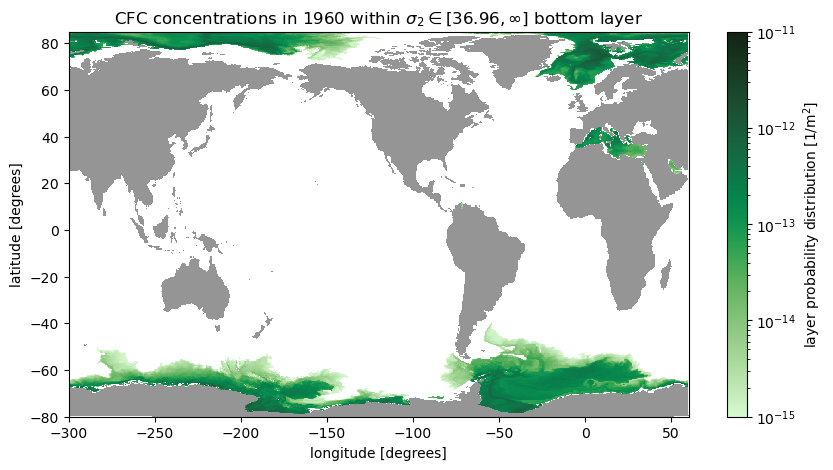

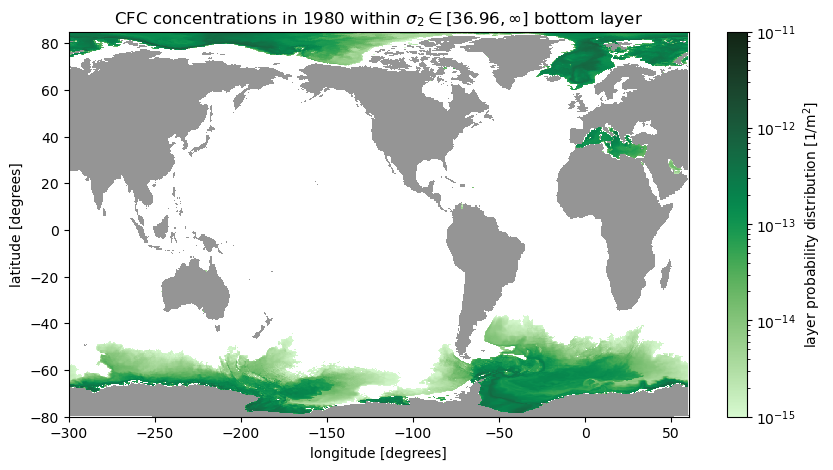

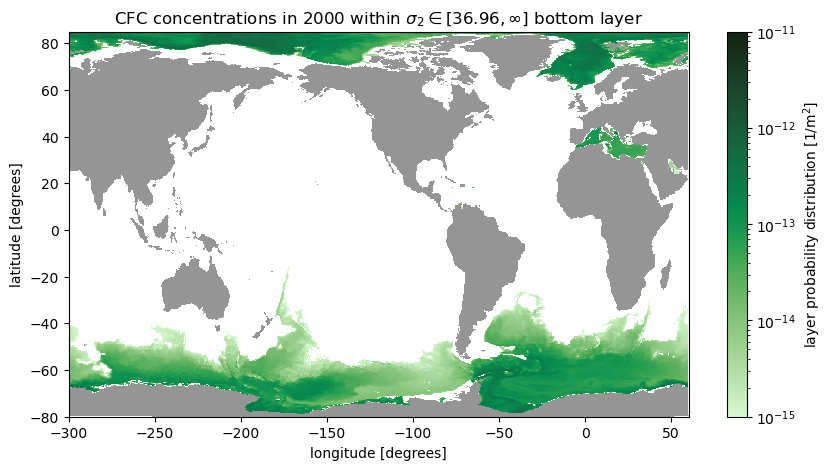

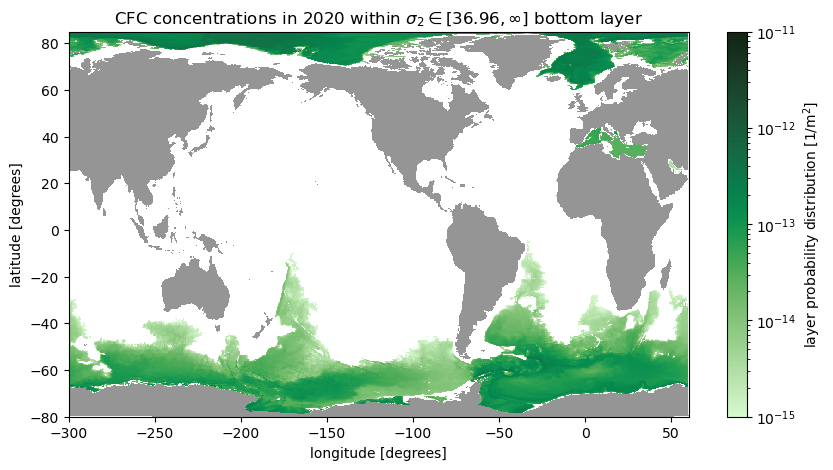

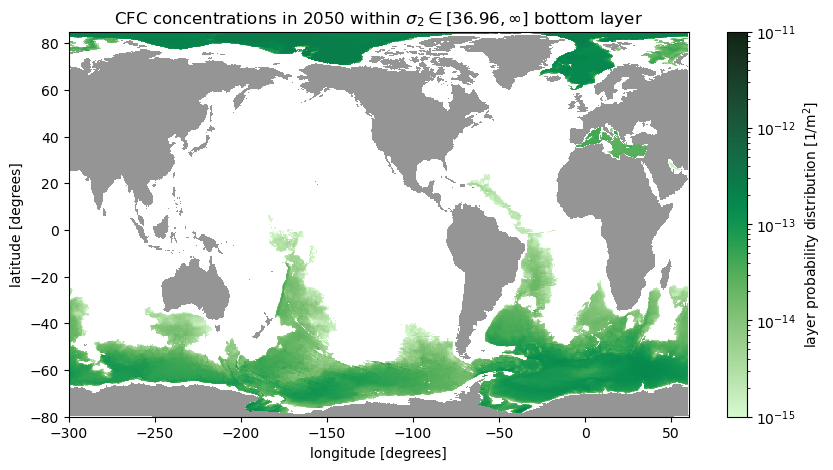

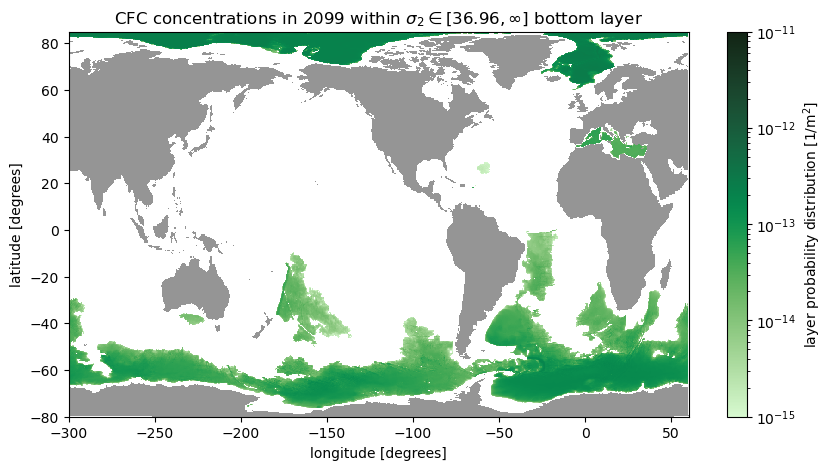

In [328]:

for layer_idx, () in zip()

    for year in years:
        cfc = (wm.grid._ds['cfc11']*ds.thkcello).fillna(0.).sel(year=year).compute() / cfc_layer_inventory.isel(sigma2=-1).sel(year=year)
        tmp = wm.grid.transform(
            cfc,
            "Z",
            np.array([36.96, 50]),
            target_data=wm.grid._ds['sigma2'].rename("sigma2_target").sel(year=year).compute(),
            method="conservative"
        ).isel(sigma2_target=0).compute()
        
        plt.figure(figsize=(10, 5))
        plt.pcolormesh(
            tmp.geolon,
            tmp.geolat,
            tmp.where(tmp>=1e-15, np.nan),
            norm=colors.LogNorm(vmin=1e-15, vmax=1e-11), cmap=cmocean.cm.algae
        )
        plt.colorbar(label=r"layer probability distribution [1/m$^{2}$]")
        plt.pcolormesh(
            tmp.geolon,
            tmp.geolat,
            ds.deptho.where(ds.deptho==0),
            cmap="Greys",
            vmin=-1, vmax=1
        )
        plt.ylim(-80, 85)
        plt.xlabel("longitude [degrees]")
        plt.ylabel("latitude [degrees]")
        plt.title(rf"CFC concentrations in {year} within the bottom water layer, $\sigma_{{2}} \in [36.96, \infty]$");
        plt.savefig(f"../figures/bottom_layer_inventory_year-{year}.png", bbox_inches="tight", dpi=300)

In [324]:
tmp = wm.grid.transform(
    cfc,
    "Z",
    np.array([36.96, 50]),
    target_data=wm.grid._ds['sigma2'].rename("sigma2_target").sel(year=year).compute(),
    method="conservative"
).isel(sigma2_target=0).compute()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


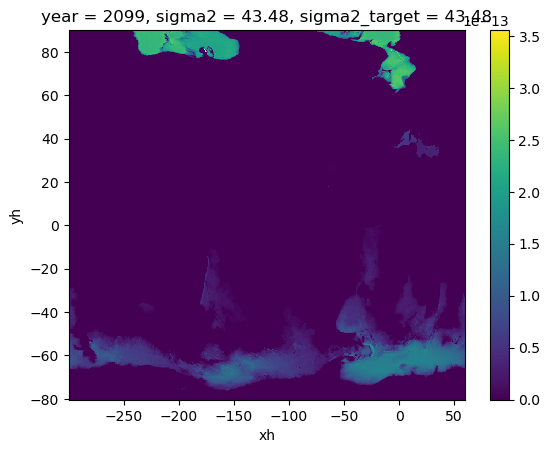

In [325]:
tmp.plot()

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vftmp/Henri

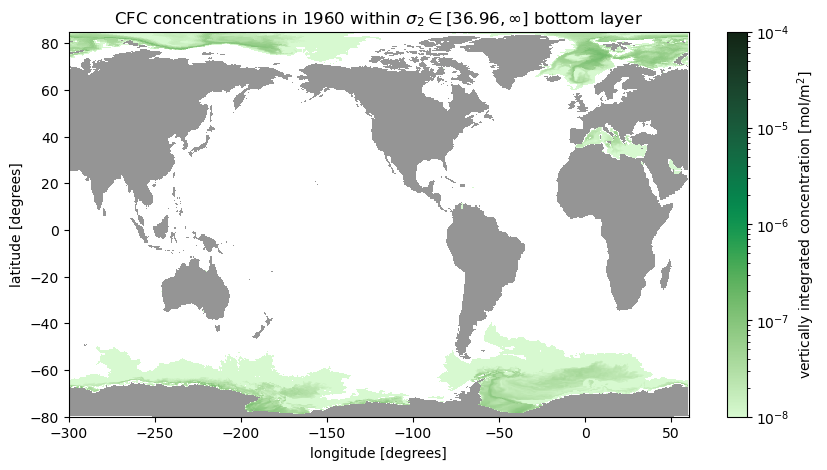

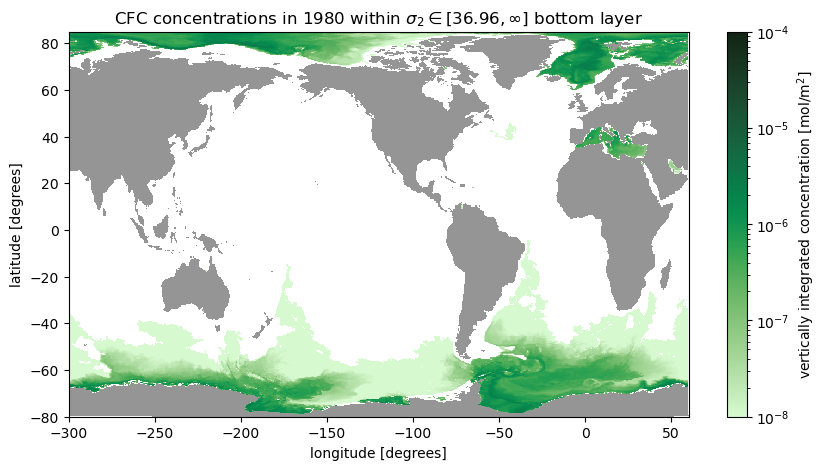

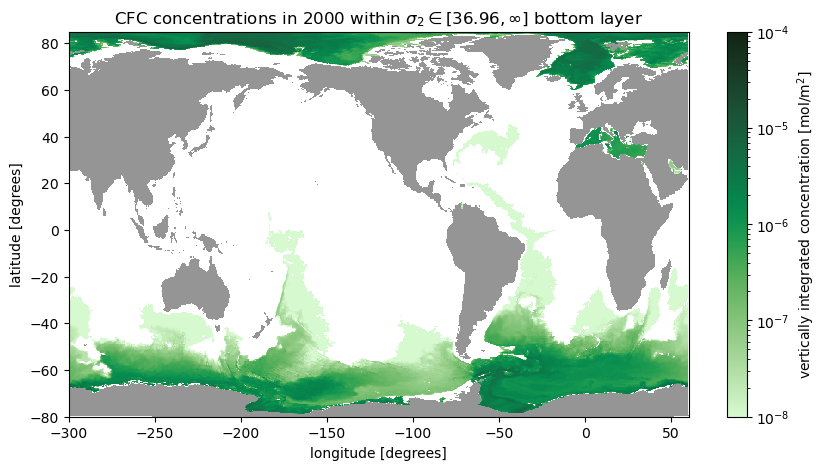

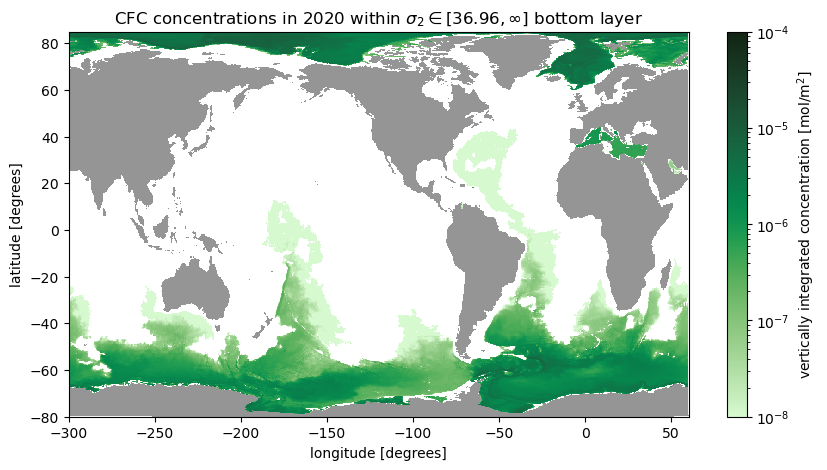

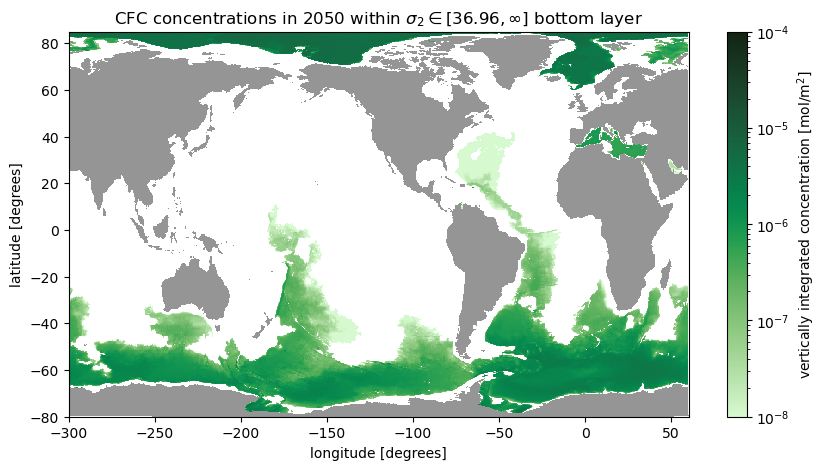

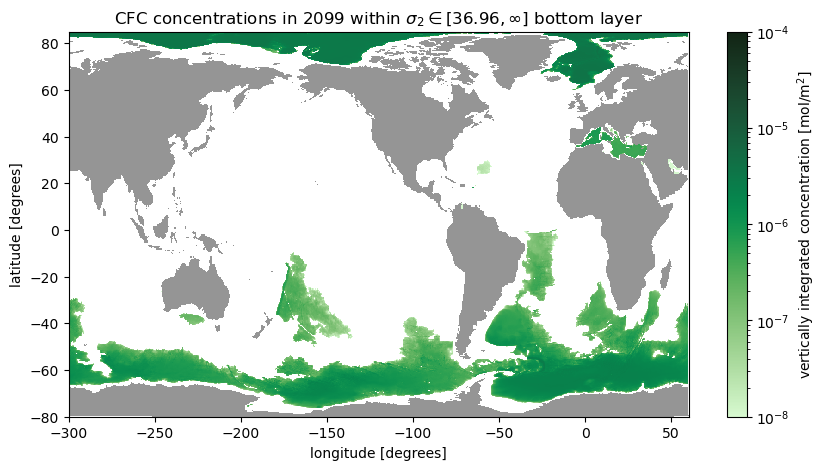

In [281]:
for year in years:
    cfc = (wm.grid._ds['cfc11']*ds.thkcello).fillna(0.).sel(year=year).compute()
    tmp = wm.grid.transform(
        cfc,
        "Z",
        np.array([36.96, 50]),
        target_data=wm.grid._ds['sigma2'].sel(year=year).compute(),
        method="conservative"
    ).isel(sigma2=0).compute()
    
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(
        tmp.geolon,
        tmp.geolat,
        tmp.where(tmp>=1e-10, np.nan),
        norm=colors.LogNorm(vmin=1e-8, vmax=1e-4), cmap=cmocean.cm.algae
    )
    plt.colorbar(label=r"vertically integrated concentration [mol/m$^{2}$]")
    plt.pcolormesh(
        tmp.geolon,
        tmp.geolat,
        ds.deptho.where(ds.deptho==0),
        cmap="Greys",
        vmin=-1, vmax=1
    )
    plt.ylim(-80, 85)
    plt.xlabel("longitude [degrees]")
    plt.ylabel("latitude [degrees]")
    plt.title(rf"CFC concentrations in {year} within $\sigma_{{2}} \in [36.96, \infty]$ bottom layer");
    plt.savefig(f"../figures/bottom_layer_inventory_year-{year}.png", bbox_inches="tight", dpi=300)

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vftmp/Henri

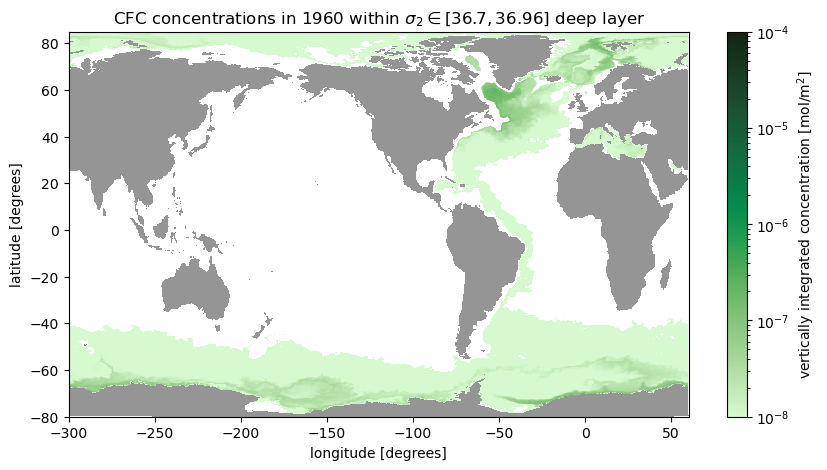

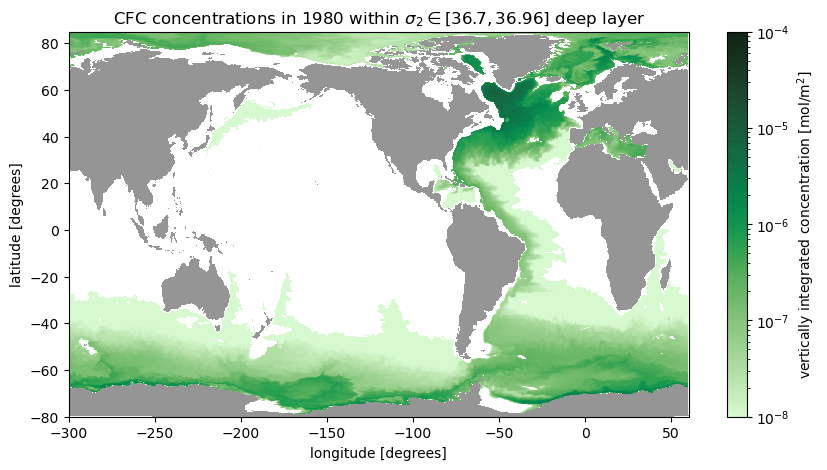

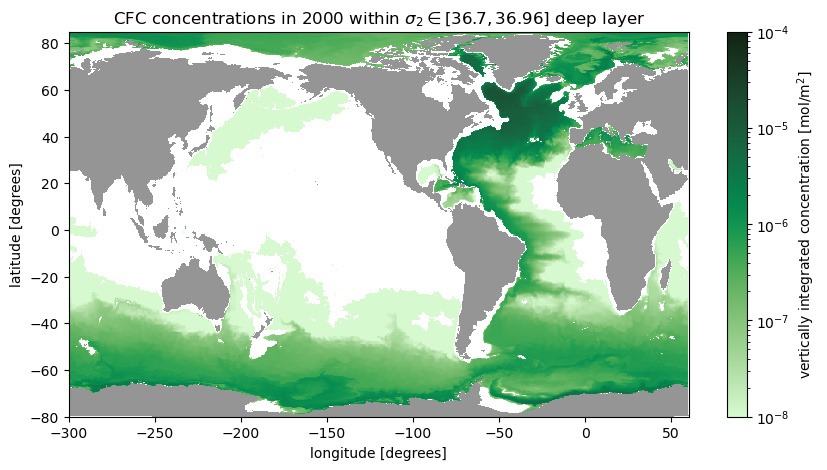

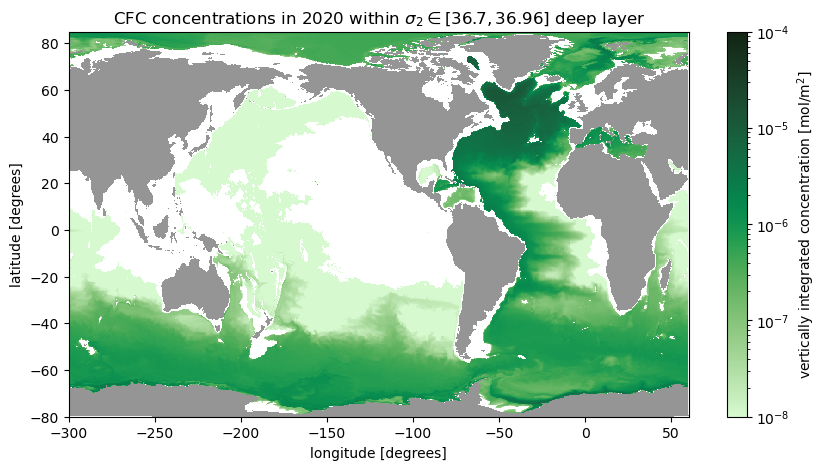

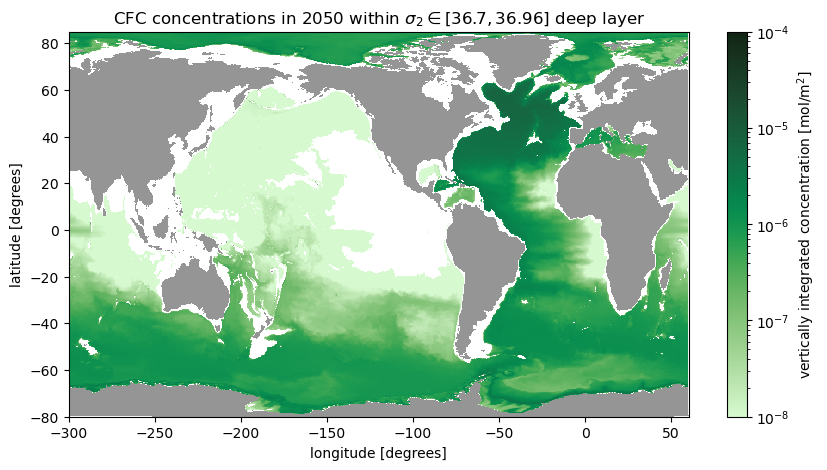

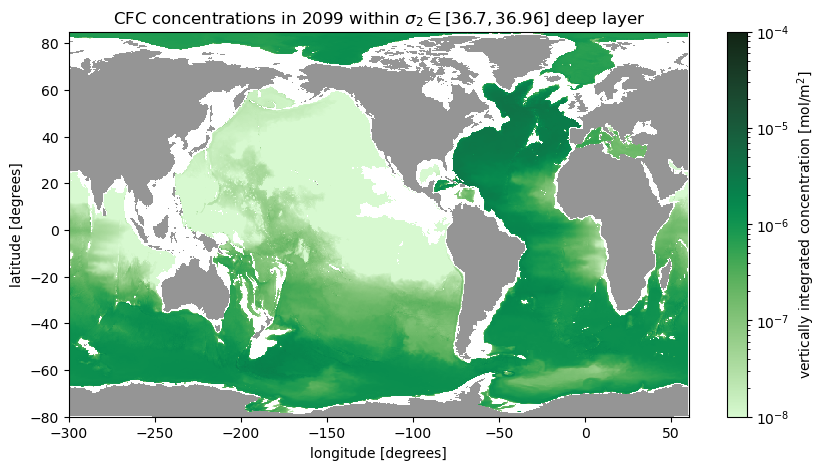

In [303]:
for year in years:
    cfc = (wm.grid._ds['cfc11']*ds.thkcello).fillna(0.).sel(year=year).compute()
    tmp = wm.grid.transform(
        cfc,
        "Z",
        np.array([36.7, 36.96]),
        target_data=wm.grid._ds['sigma2'].sel(year=year).compute(),
        method="conservative"
    ).isel(sigma2=0).compute()
    
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(
        tmp.geolon,
        tmp.geolat,
        tmp.where(tmp>=1e-10, np.nan),
        norm=colors.LogNorm(vmin=1e-8, vmax=1e-4), cmap=cmocean.cm.algae
    )
    plt.colorbar(label=r"vertically integrated concentration [mol/m$^{2}$]")
    plt.pcolormesh(
        tmp.geolon,
        tmp.geolat,
        ds.deptho.where(ds.deptho==0),
        cmap="Greys",
        vmin=-1, vmax=1
    )
    plt.ylim(-80, 85)
    plt.xlabel("longitude [degrees]")
    plt.ylabel("latitude [degrees]")
    plt.title(rf"CFC concentrations in {year} within $\sigma_{{2}} \in [36.7, 36.96]$ deep layer");
    plt.savefig(f"../figures/deep_layer_inventory_year-{year}.png", bbox_inches="tight", dpi=300)

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vftmp/Henri

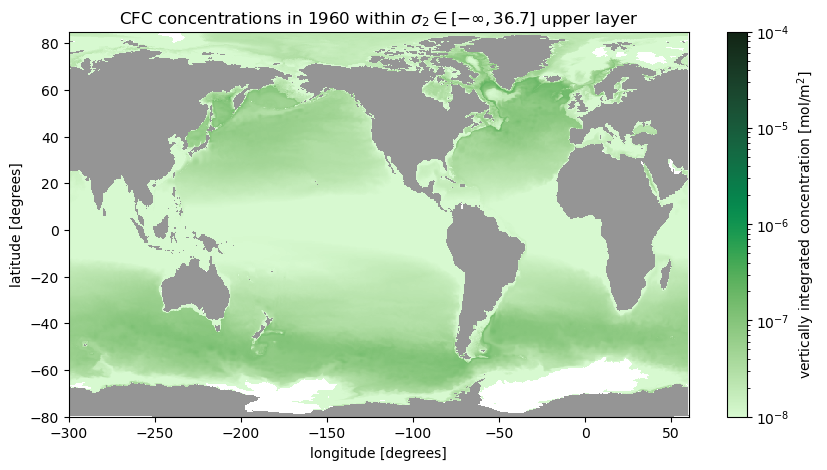

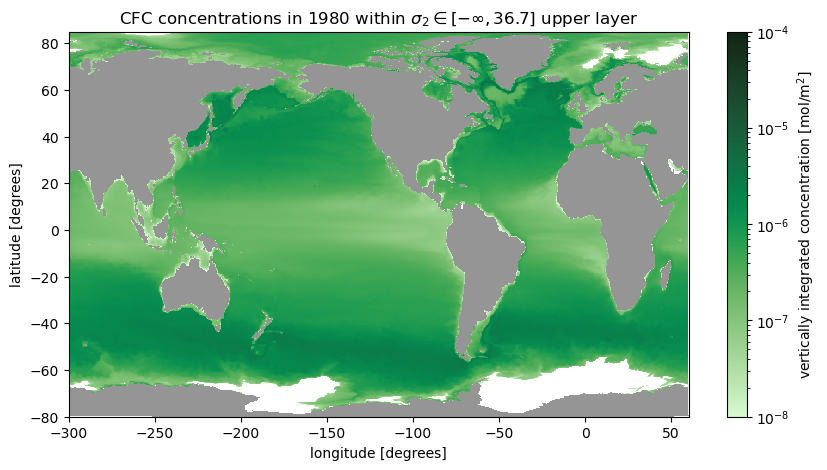

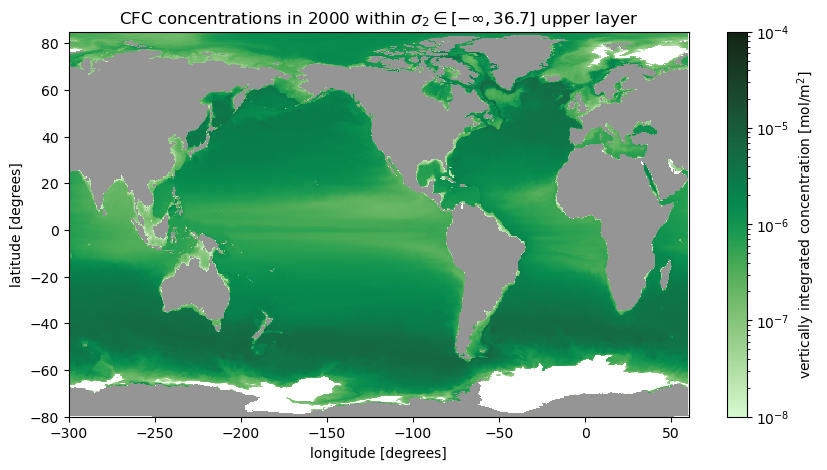

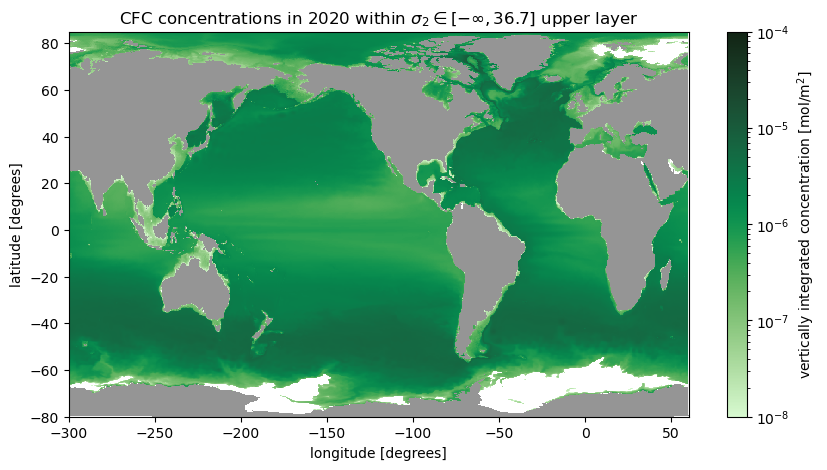

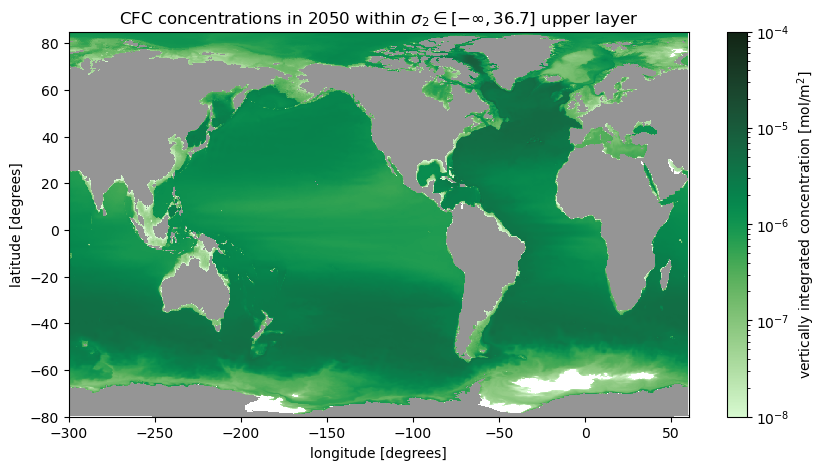

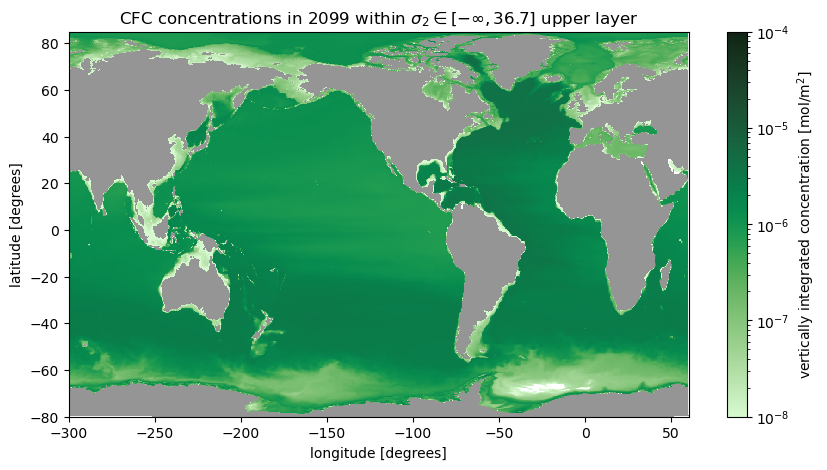

In [302]:
for year in years:
    cfc = (wm.grid._ds['cfc11']*ds.thkcello).fillna(0.).sel(year=year).compute()
    tmp = wm.grid.transform(
        cfc,
        "Z",
        np.array([0, 36.7]),
        target_data=wm.grid._ds['sigma2'].sel(year=year).compute(),
        method="conservative"
    ).isel(sigma2=0).compute()
    
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(
        tmp.geolon,
        tmp.geolat,
        tmp.where(tmp>=1e-10, np.nan),
        norm=colors.LogNorm(vmin=1e-8, vmax=1e-4), cmap=cmocean.cm.algae
    )
    plt.colorbar(label=r"vertically integrated concentration [mol/m$^{2}$]")
    plt.pcolormesh(
        tmp.geolon,
        tmp.geolat,
        ds.deptho.where(ds.deptho==0),
        cmap="Greys",
        vmin=-1, vmax=1
    )
    plt.ylim(-80, 85)
    plt.xlabel("longitude [degrees]")
    plt.ylabel("latitude [degrees]")
    plt.title(rf"CFC concentrations in {year} within $\sigma_{{2}} \in [-\infty, 36.7]$ upper layer");
    plt.savefig(f"../figures/upper_layer_inventory_year-{year}.png", bbox_inches="tight", dpi=300)